In [ ]:
#default_exp discharge

# Battery Discharging

<br>

### Problem Definition


##### Cost Function

We'll start by defining the cost function for the demand forecasting component of the battery discharge optimisation.

For each day ($𝑑$ = 1, … , 7) the peak percentage reduction is calculated using:

$$R_{d, peak} = 100\left(\frac{\max_{x\in\{32,...,42\}}\left(L_{d, k}\right) - \max_{x\in\{32,...,42\}}\left(L_{d, k}+B_{d, k}\right)}{\max_{x\in\{32,...,42\}}\left(L_{d, k}\right)}\right)$$

Where:
* $L_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, where $k = 1$ would mean the period from midnight to 00:30 AM on the current day, $d$. 
* $B_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, to minimise the peak demand over the evening period (the half hours $𝑘$ = 32 𝑡𝑜 42)

Our goal is to maximise the peak percentage reduction from 3.30PM to 9PM.

<br>

##### Constraints

We also have a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

<br>

##### Output

The desired output from the battery discharging optimisation will be an array with 11 values, one for each settlement period. As the battery profile is expressed in terms of the charge all values within the evening time period should be 0 or negative. An example profile is shown below.

```python
battery_evening_profile = [
    0,  # 15:30 - 16:00
    0,  # 16:00 - 16:30
    0,  # 16:30 - 17:00
    0,  # 17:00 - 17:30
    -2, # 17:30 - 18:00
    -2, # 18:00 - 18:30
    -2, # 18:30 - 19:00
    -2, # 19:00 - 19:30
    -2, # 19:30 - 20:00
    0,  # 20:00 - 20:30
    0,  # 20:30 - 21:00
]
```

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from moepy.lowess import Lowess, quantile_model

from batopt import clean

import os
import random
import FEAutils as hlp

<br>

### User Inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

<br>

### Preparing Data

In [4]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,,,,,
2017-11-03 00:00:00+00:00,2.19,0.0,7.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.560,9.640,7.46,6.680,13.090,13.20
2017-11-03 00:30:00+00:00,2.14,0.0,7.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.625,9.675,7.30,6.475,13.150,13.26
2017-11-03 01:00:00+00:00,2.01,0.0,7.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.690,9.710,7.14,6.270,13.210,13.32
2017-11-03 01:30:00+00:00,1.87,0.0,7.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.715,9.720,7.00,6.090,13.255,13.34
2017-11-03 02:00:00+00:00,1.86,0.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.740,9.730,6.86,5.910,13.300,13.36


In [5]:
#exports
def construct_df_features(df):
    df_features = df[df.columns[df.columns.str.contains('temp_location')]].copy()

    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    
    return df_features

In [6]:
df_features = construct_df_features(df)

df_features.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,weekend,hour
datetime,,,,,,,,
2017-11-03 00:00:00+00:00,8.560,9.640,7.46,6.680,13.090,13.20,0,0.0
2017-11-03 00:30:00+00:00,8.625,9.675,7.30,6.475,13.150,13.26,0,0.5
2017-11-03 01:00:00+00:00,8.690,9.710,7.14,6.270,13.210,13.32,0,1.0
2017-11-03 01:30:00+00:00,8.715,9.720,7.00,6.090,13.255,13.34,0,1.5
2017-11-03 02:00:00+00:00,8.740,9.730,6.86,5.910,13.300,13.36,0,2.0


<br>

### Exploratory Demand Analysis

We'll start by exploring the relationship between time of day and demand, in this instance fitting a quantile LOWESS model to get a probabilistic view of likely loads at specific times of day

In [7]:
#exports
def estimate_daily_demand_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

In [8]:
x = df_features['hour'].values
y = df['demand_MW'].values

rerun_daily_demand_model = False
daily_demand_filename = 'daily_demand_quantile_model_results.csv'

if (rerun_daily_demand_model == True) or (daily_demand_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_demand_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_demand_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_demand_filename}', index_col='x')

df_quantiles.head()

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
0.000000,2.798489,2.712288,2.646407,2.561911,2.397012,2.106675,1.889666,1.819768,1.770966
0.237374,2.761870,2.675973,2.608709,2.527495,2.369704,2.090690,1.868746,1.795846,1.745769
0.474747,2.725316,2.639735,2.571162,2.493121,2.342462,2.074400,1.847965,1.771846,1.720577
0.712121,2.688708,2.603480,2.533552,2.458632,2.315333,2.057938,1.827455,1.747588,1.695216
0.949495,2.652125,2.567372,2.496137,2.424161,2.288293,2.040857,1.807044,1.723191,1.669598


<br>

We'll now visualise these quantile fits alongside the raw data

N.b. the x values have been slightly jittered in order to make their distribution easier to visualise

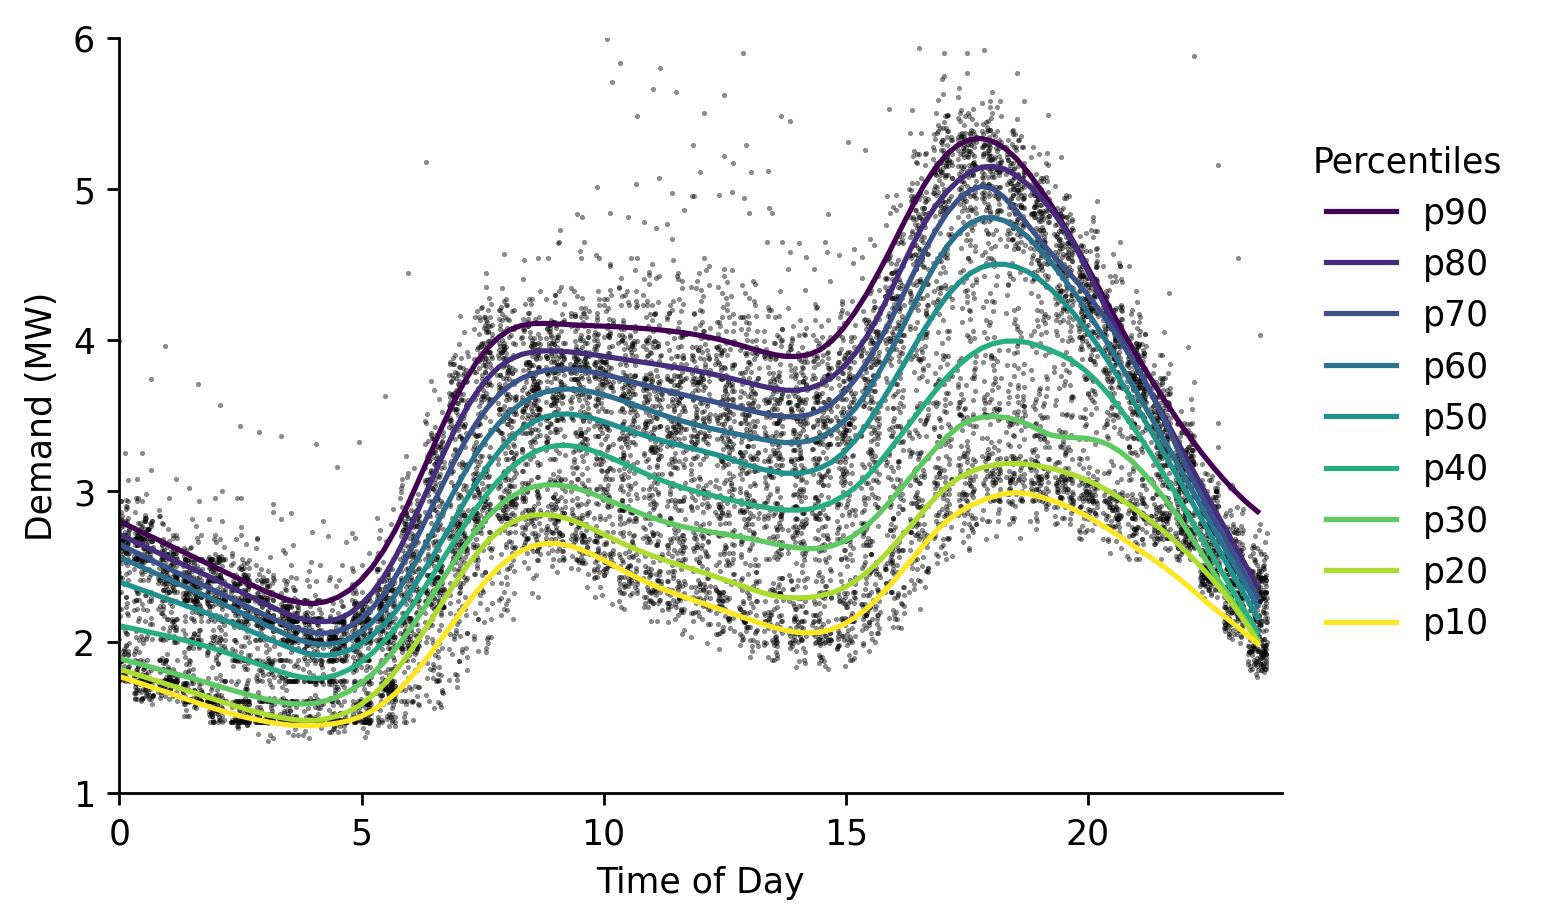

In [9]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(1, 6)

fig.savefig('../img/daily_demand_profile.png')

In [10]:
s_peak_demand_period_pct_coverage = (df
                                     ['demand_MW']
                                     .groupby(df.index.date)
                                     .idxmax()
                                     .pipe(lambda s: s.dt.hour+s.dt.minute/60)
                                     .value_counts()
                                     .cumsum()
                                     .pipe(lambda s: s/s.max())
                                     .multiply(100)
                                    )

s_peak_demand_period_pct_coverage

17.0     31.297710
17.5     55.725191
18.0     73.664122
18.5     81.297710
16.0     87.404580
16.5     91.603053
19.0     94.274809
6.5      96.564885
19.5     97.709924
20.0     98.473282
7.5      98.854962
8.0      99.236641
9.5      99.618321
12.5    100.000000
Name: demand_MW, dtype: float64

In [11]:
#exports
reset_idx_dt = lambda s, dt='2020-01-01': s.index - (s.index[0]-pd.to_datetime(dt, utc=True))

def sample_random_day(s):
    random_dt = random.choice(s.index.date)
    s_sample_dt = s.loc[str(random_dt)]
    
    return s_sample_dt

def sample_random_days(s, num_days=5):
    df_sample_dts = pd.DataFrame()

    for _ in range(num_days):
        s_sample_dt = sample_random_day(s)
        dt = str(s_sample_dt.index[0].date())
        s_sample_dt.index = reset_idx_dt(s_sample_dt)
        df_sample_dts[dt] = s_sample_dt
        
    df_sample_dts = df_sample_dts.sort_index(axis=1)

    return df_sample_dts

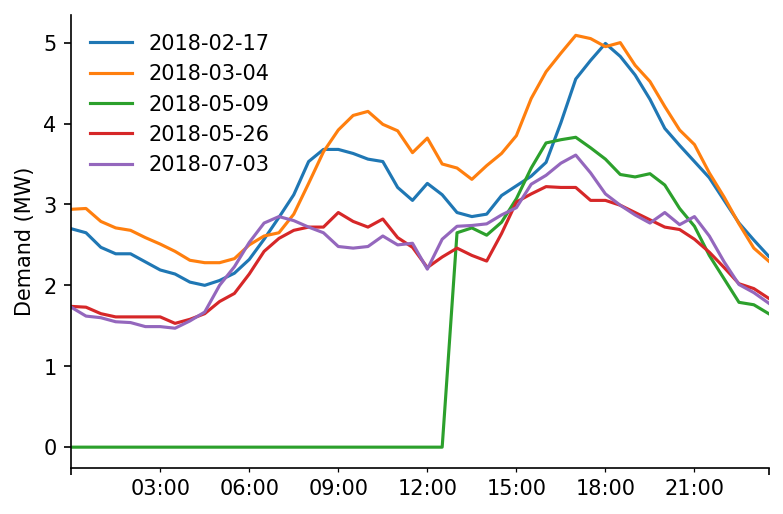

In [14]:
s_demand = df['demand_MW']
df_sample_dts = sample_random_days(s_demand)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

df_sample_dts.plot(ax=ax)

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Demand (MW)')

_ = plt.setp(ax.get_xmajorticklabels(), visible=False)

<br>

### Strategy Development with Perfect Foresight

We'll start by developing a charging strategy for when we have perfect foresight

In [41]:
#exports
def extract_evening_demand_profile(s_demand_sample_dt, start_time='15:30', end_time='20:30'):
    dt = str(s_demand_sample_dt.index[0].date())
    evening_demand_profile = s_demand_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return evening_demand_profile

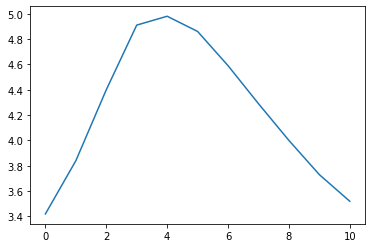

In [250]:
evening_demand_profile = sample_random_day(s_demand).pipe(extract_evening_demand_profile)

plt.plot(evening_demand_profile)

In [251]:
#exports
def flatten_peak(evening_demand_profile, charge=6):
    peak = max(evening_demand_profile)
    adj_evening_demand_profile = evening_demand_profile.copy()

    while charge > 0:
        num_periods_plateaued = (evening_demand_profile>=peak).sum()

        # If the evening demand profile has been fully flattened
        # then split up the remaining charge equally across all SPs
        fully_flattened = len(set(adj_evening_demand_profile)) == 1

        if fully_flattened == True:
            remaining_discharge_rate_for_each_SP = 2*charge/len(adj_evening_demand_profile)
            adj_evening_demand_profile -= remaining_discharge_rate_for_each_SP
            charge = 0
            break

        # If there is still a peak then determine the next highest value 
        else:
            peak = max(adj_evening_demand_profile)
            highest_non_peak = max(adj_evening_demand_profile[peak>adj_evening_demand_profile])

            proposed_additional_discharge = 0.5*(adj_evening_demand_profile.sum() - np.minimum(adj_evening_demand_profile, highest_non_peak).sum())

        # if its possible to reduce the peak to the next highest value do so
        if charge >= proposed_additional_discharge:
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, highest_non_peak)
            charge -= proposed_additional_discharge

        # If the capacity constraints are broken in reducing to the next highest value
        # then lower the current peak as far as possible
        else:
            new_peak = peak - (2*charge/(num_periods_plateaued+1))
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, new_peak)
            charge = 0

    return adj_evening_demand_profile

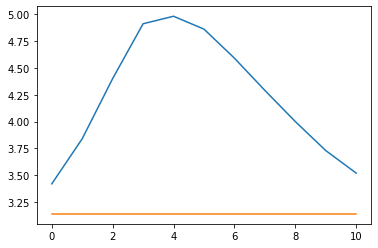

In [252]:
adj_evening_demand_profile = flatten_peak(evening_demand_profile)

plt.plot(evening_demand_profile)
plt.plot(adj_evening_demand_profile)

In [256]:
#exports
generate_discharge_profile = lambda evening_demand_profile, adj_evening_demand_profile: -(evening_demand_profile - adj_evening_demand_profile)

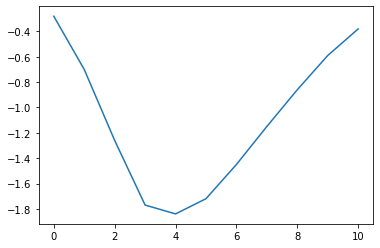

In [257]:
discharge_profile = generate_discharge_profile(evening_demand_profile, adj_evening_demand_profile)

plt.plot(discharge_profile)

In [ ]:
# create func to pass demand series and get perfect discharge series back
# then plot showing the peak shaving and battery discharge

<br>

### Strategy Development under Uncertainty

In [ ]:
# could use public holiday data 

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()